# Tema 4: Perceptronul multistrat - Pytorch


## Termen de predare: 12 ianuarie 2024, ora 23:00

## Descrierea temei
În cadrul acestei teme veți avea de implementat perceptronul multistrat în Pytorch. Veți lucra cu setul de date [FashionMnist](hhttps://www.kaggle.com/datasets/zalando-research/fashionmnist).

Puteți reutiliza și adapta cod din exemplul Pytorch pentru regresia logistică binară, din fișierul `Regresie logistică binomială` încărcat pe platformă în cadrul întâlnirii din 26 noiembrie. Modificările pe care trebuie să le aveți în vedere sunt:

1. În definirea lui Dataset nu se mai face filtrare după clasele pozitive si negative; se lasă toate datele (toate cele 10 clase)
1. În definirea clasei modelului, stratul self.fully_connected trebuie să fie cu numărul de ieșiri egal cu numărul de clase.
1. La predicție, pentru fiecare vector de intrare (imaginea reprezentată ca vector de 784 de valori) modelul produce un vector de 10 probabilități. Clasa se decide ca indicele pe care probabilitatea este maximă. Aceasta afectează implementarea funcției de testare
1. Funcția de eroare loss_fn este `torch.nn.CrossEntropyLoss`. Aceasta preia logiții produși de model.
1. Creați o matrice de confuzie pentru clase; puteți folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

 



In [22]:
import numpy as np
import torch 
from torch import nn, save, load
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


train = datasets.FashionMNIST(root="data", download=True, train=True, transform=ToTensor())
train_dataset = DataLoader(train, batch_size=32, shuffle=True)

test = datasets.FashionMNIST(root="data", download=True, train=False, transform=ToTensor())
test_dataset = DataLoader(test,batch_size=32, shuffle=False)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("You are using: ", device)
    
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        return self.model(x)
    
    
Fashion_classifier = ImageClassifier().to(device)
optimizer = SGD(Fashion_classifier.parameters(), lr = 0.001)
loss_function = nn.CrossEntropyLoss()

def test(model: nn.Module, loader: DataLoader, cm = False) -> float:
    if cm == True:
        y_true = []
        y_pred = []
    correctly_classified = 0
    total_items = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            pred = torch.argmax(model(x), dim=1)
            correctly_classified += (pred == y).sum().item()

            if cm == True:
                y_true.append(y.cpu().numpy().squeeze())  # Convert y tensor to CPU and then to NumPy array
                y_pred.append(pred.cpu().numpy().squeeze()) 
            total_items += len(x)
    accuracy = correctly_classified / total_items
    if cm:
        y_true = np.concatenate(y_true)  # Concatenate the list of arrays into a single array
        y_pred = np.concatenate(y_pred)  # Concatenate the list of arrays into a single array
        return accuracy, y_true, y_pred
    else:
        return accuracy
    
if __name__=="__main__":
    
    #with open('model_state.pt', 'rb') as f: 
    #    Fashion_classifier.load_state_dict(load(f))
    epochs = 20
    accuracy_train = []
    accuracy_test = []
    losses = []
    for epoch in range(epochs):
        Fashion_classifier.train()
        for batch in train_dataset: 
            x, y = batch
            x, y = x.to(device), y.to(device)
            yhat = Fashion_classifier(x)
            loss = loss_function(yhat,y)
            
            #Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
            
        print(f"Epoch:{epoch} loss is {loss.item()}")
        losses.append(loss.item())
        
        accuracy_train.append(test(Fashion_classifier, train_dataset))
        accuracy_test.append(test(Fashion_classifier, test_dataset))
        
    #with open('model_state.pt', 'wb') as f: 
    #    save(Fashion_classifier.state_dict(), f) 
    
    print("Accuracy is ", accuracy_test[-1])

    
        


You are using:  cuda
Epoch:0 loss is 2.137918710708618
Epoch:1 loss is 1.4784530401229858
Epoch:2 loss is 1.1163370609283447
Epoch:3 loss is 0.913866400718689
Epoch:4 loss is 0.8658226728439331
Epoch:5 loss is 0.6239702701568604
Epoch:6 loss is 0.6935197114944458
Epoch:7 loss is 0.88390052318573
Epoch:8 loss is 0.6457492113113403
Epoch:9 loss is 0.6420177221298218
Epoch:10 loss is 0.7963209748268127
Epoch:11 loss is 0.690767765045166
Epoch:12 loss is 0.6827536821365356
Epoch:13 loss is 0.38349649310112
Epoch:14 loss is 0.6809612512588501
Epoch:15 loss is 0.27506282925605774
Epoch:16 loss is 0.6891606450080872
Epoch:17 loss is 0.5636635422706604
Epoch:18 loss is 0.5481048226356506
Epoch:19 loss is 0.3583720028400421
Accuracy is  0.8059



## Suplimentar (și obligatoriu)
1. Pe un alt grafic să se prezinte: acuratețea pe setul de antrenare și pe setul de testare, la finalul fiecărei epoci (ambele scoruri pe acelasi grafic, cu legendă).
1. Să se calculeze și  să se afiseze matricea de confuzie (puteți folosi [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)).



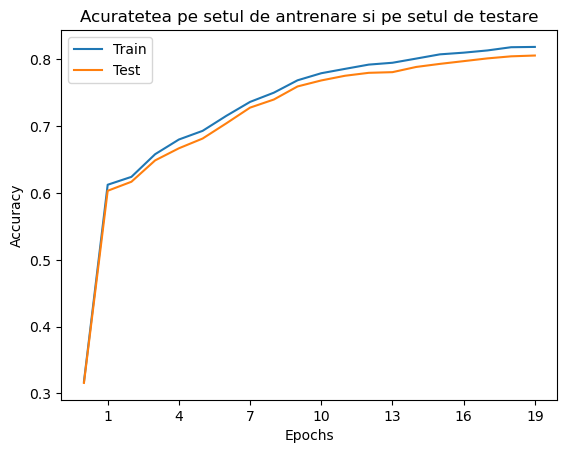

In [29]:
plt.plot(accuracy_train, label = "Train")
plt.plot(accuracy_test, label = "Test")
plt.title("Acuratetea pe setul de antrenare si pe setul de testare")
plt.legend()
epoch_ticks = list(range(1, 21,3))
plt.xticks(epoch_ticks)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

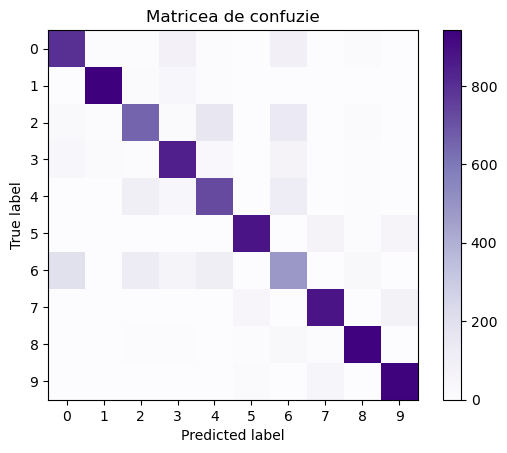

In [24]:
accuracy, y_true, y_pred = test(Fashion_classifier,test_dataset, True)

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Matricea de confuzie")
classes = np.arange(10)
plt.xticks(classes)
plt.yticks(classes)
plt.colorbar()
plt.show()

## Suplimentar (opțional)

1. Pe un grafic să se prezinte loss-ul la finalul fiecărei epoci, pe setul de antrenare. Funcția de loss este aceeași ca în logistic regression, cazul multinomial
1. Implementați modificare de ponderi folosind metoda momentum.
1. Matricea de confuzie ca procent + colorare heatmap.

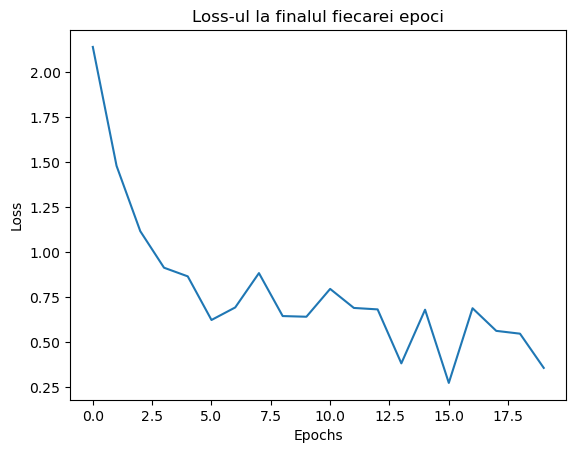

In [30]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss-ul la finalul fiecarei epoci")
plt.show()

In [32]:
Fashion_classifier_momentum = ImageClassifier().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(Fashion_classifier_momentum.parameters(), lr=0.001, momentum=0.9)

accuracy_train_momentum=[]
accuracy_test_momentum=[]
for epoch in range(epochs):
    Fashion_classifier_momentum.train()
    for batch in train_dataset:
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = Fashion_classifier_momentum(x)
        loss = loss_function(yhat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch:{epoch} loss is {loss.item()}")

    accuracy_train_momentum.append(test(Fashion_classifier_momentum, train_dataset))
    accuracy_test_momentum.append(test(Fashion_classifier_momentum, test_dataset))

Epoch:0 loss is 0.5750742554664612
Epoch:1 loss is 0.5560204386711121
Epoch:2 loss is 0.38230210542678833
Epoch:3 loss is 0.3221980929374695
Epoch:4 loss is 0.28442448377609253
Epoch:5 loss is 0.5397574305534363
Epoch:6 loss is 0.2881515622138977
Epoch:7 loss is 0.23280800879001617
Epoch:8 loss is 0.2652439475059509
Epoch:9 loss is 0.43492573499679565
Epoch:10 loss is 0.37915003299713135
Epoch:11 loss is 0.21065549552440643
Epoch:12 loss is 0.5075811743736267
Epoch:13 loss is 0.23793277144432068
Epoch:14 loss is 0.14538103342056274
Epoch:15 loss is 0.2551063895225525
Epoch:16 loss is 0.1906820684671402
Epoch:17 loss is 0.23518039286136627
Epoch:18 loss is 0.43134623765945435
Epoch:19 loss is 0.26065894961357117


In [34]:
print("Accuracy with momentum is:",accuracy_test_momentum[-1])

Accuracy with momentum is: 0.8685


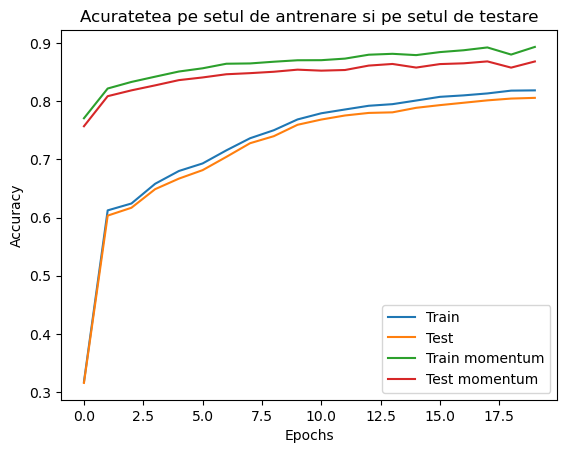

In [33]:
# Suplimentar
# Am vrut sa vad diferenta in acuratete dintre metoda clasica si metoda momentum
plt.plot(accuracy_train, label ="Train")
plt.plot(accuracy_test, label ="Test")
plt.plot(accuracy_train_momentum,  label ="Train momentum")
plt.plot(accuracy_test_momentum,  label ="Test momentum")
plt.title("Acuratetea pe setul de antrenare si pe setul de testare")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

<Figure size 800x600 with 0 Axes>

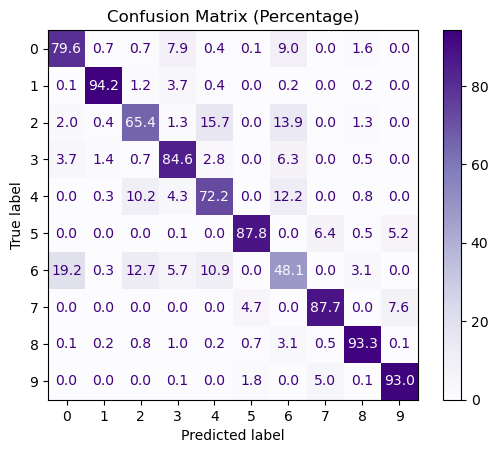

In [39]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Purples, values_format=".1f") 
plt.title('Confusion Matrix (Percentage)')
plt.show()